In [7]:
#label이 없는 유의미한 feature만 뽑아내는데 사용함
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")

PACKAGES LOADED


# MNIST

In [8]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


# Define Network

In [11]:
# Network Parameters
n_input    = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 256 # 1st layer num features
n_hidden_center = 128 # 3rd layer 
n_hidden_2 = 256 # 2nd layer num features
n_output   = 784 # 
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_output])
dropout_keep_prob = tf.placeholder("float")
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'hc': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_center])),
    'h2': tf.Variable(tf.random_normal([n_hidden_center, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'bc': tf.Variable(tf.random_normal([n_hidden_center])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}
# Create model
def denoising_autoencoder(_X, _weights, _biases, _keep_prob):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1out = tf.nn.dropout(layer_1, _keep_prob) 
    
    layer_c = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['hc']), _biases['bc'])) 
    layer_cout = tf.nn.dropout(layer_c, _keep_prob) 
    
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_cout, _weights['h2']), _biases['b2'])) 
    layer_2out = tf.nn.dropout(layer_2, _keep_prob) 
    return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])
print ("NETWORK READY")

NETWORK READY


# Define Functions

In [12]:
# MODEL
out = denoising_autoencoder(x, weights, biases, dropout_keep_prob)
# DEFINE LOSS AND OPTIMIZER
# cost = tf.reduce_mean(tf.pow(out-y, 2))
cost = tf.reduce_mean(tf.abs(out-y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost) 
# INITIALIZE
init = tf.global_variables_initializer()
# SAVER
savedir = "data/nets/"
saver = tf.train.Saver(max_to_keep=3) 
print ("FUNCTIONS READY")

FUNCTIONS READY


In [ ]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True))
sess.run(init)

START OPTIMIZATION
Epoch: 000/030 cost: 0.133612559


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


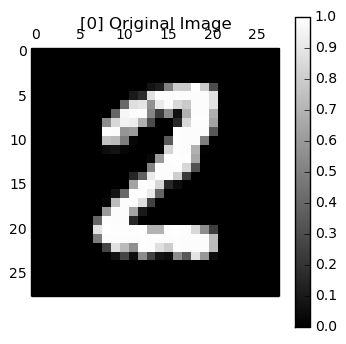

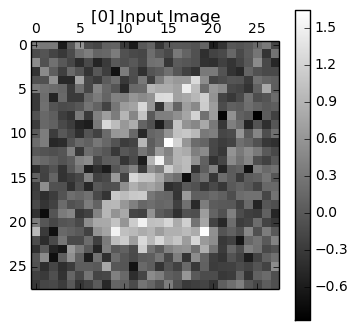

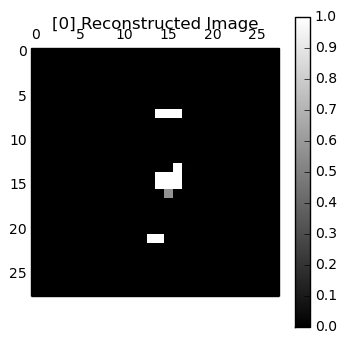

In [ ]:
training_epochs = 30
batch_size      = 100
display_step    = 5
plot_step       = 10
if do_train:
    print ("START OPTIMIZATION")
    for epoch in range(training_epochs):
        avg_cost = 0.
        num_batch = int(mnist.train.num_examples/batch_size)
        for i in range(num_batch): 
            randidx = np.random.randint(trainimg.shape[0], size=batch_size)
            batch_xs = trainimg[randidx, :]
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_xs.shape[0], 784)
            feed1 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 0.5}
            sess.run(optimizer, feed_dict=feed1)
            feed2 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 1}
            avg_cost += sess.run(cost, feed_dict=feed2)/num_batch

        # DISPLAY
        if epoch % display_step == 0:
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        if epoch % plot_step == 0 or epoch == training_epochs-1:
            # TEST
            randidx  = np.random.randint(testimg.shape[0], size=1)
            testvec  = testimg[randidx, :]
            noisyvec = testvec + 0.3*np.random.randn(1, 784)
            outvec   = sess.run(out, feed_dict={x: testvec, dropout_keep_prob: 1.})
            outimg   = np.reshape(outvec, (28, 28))

            # PLOT 
            plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Original Image")
            plt.colorbar()
            plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Input Image")
            plt.colorbar()
            plt.matshow(outimg, cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Reconstructed Image")
            plt.colorbar()
            plt.show()

            # SAVE
            saver.save(sess, savedir + 'dae_dr.ckpt', global_step=epoch)
            
    print ("Optimization Finished!")
else:
    print ("RESTORE")
    saver.restore(sess, "nets/dae_dr.ckpt-" + str(training_epochs-1))

In [ ]:
# pow loss 가 아닌 squard loss를 사용하게 되면 윤곽선이 선명하게 나온다(abs) : abs로 loss잡아서 결과값도 보기